# Cora dataset

In [23]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
from dgl.data import citation_graph as citegrh
import networkx as nx
import time
import numpy as np
from tqdm import tqdm

In [8]:
gcn_msg = fn.copy_src(src='h', out='m')
gcn_reduce = fn.sum(msg='m', out='h')

In [9]:
class GCNLayer(nn.Module):
    def __init__(self, in_feats, out_feats):
        super(GCNLayer, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
    def forward(self, g, feature):
        with g.local_scope():
            g.ndata['h'] = feature
            g.update_all(gcn_msg, gcn_reduce)
            h = g.ndata['h']
            return self.linear(h)

In [10]:

def load_cora_data():
    data = citegrh.load_cora()
    features = th.FloatTensor(data.features)
    labels = th.LongTensor(data.labels)
    train_mask = th.BoolTensor(data.train_mask)
    test_mask = th.BoolTensor(data.test_mask)
    g = DGLGraph(data.graph)
    return g, features, labels, train_mask, test_mask

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.layer1 = GCNLayer(1433, 16)
        self.layer2 = GCNLayer(16, 7)
    def forward(self, g, features):
        x = F.relu(self.layer1(g, features))
        x = self.layer2(g, x)
        return x


In [12]:
net = Net()

In [13]:
net

Net(
  (layer1): GCNLayer(
    (linear): Linear(in_features=1433, out_features=16, bias=True)
  )
  (layer2): GCNLayer(
    (linear): Linear(in_features=16, out_features=7, bias=True)
  )
)

In [14]:
def evaluate(model, g, features, labels, mask):
    model.eval();
    with th.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = th.max(logits, dim = 1)
        correct = th.sum(indices==labels)
        return correct.item()*1.0/len(labels)
    

In [21]:
g, features, labels, train_mask, test_mask = load_cora_data()
optimizer = th.optim.AdamW(net.parameters(), lr=1e-2)


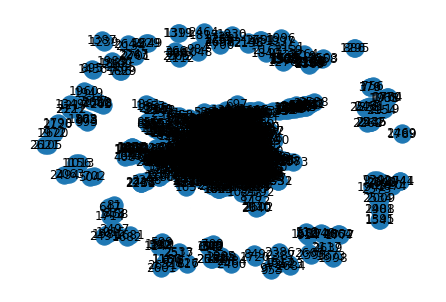

In [20]:
nx.draw(g.to_networkx(), with_labels=True)

In [22]:
dur = []

In [24]:
all_logits = []

In [25]:
for epoch in tqdm(range(50)):
    if epoch>=3:
        t0 = time.time()
    net.train();
    logits = net(g, features)
    all_logits.append(logits.detach())
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask],labels[train_mask])
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if epoch>=3:
        dur.append(time.time()-t0)
    
    acc = evaluate(net, g, features, labels, test_mask)
    
    print("Epoch {:05d} | Loss {:.4f} | Test Acc {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), acc, np.mean(dur)))
    

  0%|          | 0/50 [00:00<?, ?it/s]/home/subhaditya/anaconda3/envs/myenv/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/subhaditya/anaconda3/envs/myenv/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
  6%|▌         | 3/50 [00:01<00:39,  1.18it/s]

Epoch 00000 | Loss 2.0201 | Test Acc 0.2470 | Time(s) nan
Epoch 00001 | Loss 1.8951 | Test Acc 0.3480 | Time(s) nan
Epoch 00002 | Loss 1.7069 | Test Acc 0.3980 | Time(s) nan


 10%|█         | 5/50 [00:01<00:27,  1.62it/s]

Epoch 00003 | Loss 1.5221 | Test Acc 0.4470 | Time(s) 0.0437
Epoch 00004 | Loss 1.3799 | Test Acc 0.4850 | Time(s) 0.0435
Epoch 00005 | Loss 1.2742 | Test Acc 0.5350 | Time(s) 0.0451


 18%|█▊        | 9/50 [00:01<00:13,  2.96it/s]

Epoch 00006 | Loss 1.1841 | Test Acc 0.5860 | Time(s) 0.0451
Epoch 00007 | Loss 1.1021 | Test Acc 0.6170 | Time(s) 0.0428
Epoch 00008 | Loss 1.0269 | Test Acc 0.6470 | Time(s) 0.0408
Epoch 00009 | Loss 0.9587 | Test Acc 0.6580 | Time(s) 0.0396


 26%|██▌       | 13/50 [00:02<00:07,  4.92it/s]

Epoch 00010 | Loss 0.8967 | Test Acc 0.6750 | Time(s) 0.0388
Epoch 00011 | Loss 0.8400 | Test Acc 0.6880 | Time(s) 0.0381
Epoch 00012 | Loss 0.7872 | Test Acc 0.7130 | Time(s) 0.0391


 34%|███▍      | 17/50 [00:02<00:04,  7.41it/s]

Epoch 00013 | Loss 0.7380 | Test Acc 0.7200 | Time(s) 0.0395
Epoch 00014 | Loss 0.6920 | Test Acc 0.7300 | Time(s) 0.0399
Epoch 00015 | Loss 0.6488 | Test Acc 0.7410 | Time(s) 0.0395
Epoch 00016 | Loss 0.6083 | Test Acc 0.7570 | Time(s) 0.0388


 38%|███▊      | 19/50 [00:02<00:03,  8.54it/s]

Epoch 00017 | Loss 0.5703 | Test Acc 0.7670 | Time(s) 0.0384
Epoch 00018 | Loss 0.5350 | Test Acc 0.7710 | Time(s) 0.0389
Epoch 00019 | Loss 0.5029 | Test Acc 0.7740 | Time(s) 0.0388


 46%|████▌     | 23/50 [00:02<00:02, 10.38it/s]

Epoch 00020 | Loss 0.4740 | Test Acc 0.7780 | Time(s) 0.0387
Epoch 00021 | Loss 0.4473 | Test Acc 0.7840 | Time(s) 0.0388
Epoch 00022 | Loss 0.4217 | Test Acc 0.7900 | Time(s) 0.0388


 50%|█████     | 25/50 [00:02<00:02, 10.77it/s]

Epoch 00023 | Loss 0.3976 | Test Acc 0.7940 | Time(s) 0.0391
Epoch 00024 | Loss 0.3756 | Test Acc 0.7940 | Time(s) 0.0393
Epoch 00025 | Loss 0.3558 | Test Acc 0.7930 | Time(s) 0.0393


 58%|█████▊    | 29/50 [00:03<00:01, 11.26it/s]

Epoch 00026 | Loss 0.3378 | Test Acc 0.7960 | Time(s) 0.0395
Epoch 00027 | Loss 0.3210 | Test Acc 0.7990 | Time(s) 0.0396
Epoch 00028 | Loss 0.3050 | Test Acc 0.7990 | Time(s) 0.0396


 62%|██████▏   | 31/50 [00:03<00:01, 11.69it/s]

Epoch 00029 | Loss 0.2900 | Test Acc 0.7970 | Time(s) 0.0397
Epoch 00030 | Loss 0.2762 | Test Acc 0.7980 | Time(s) 0.0397
Epoch 00031 | Loss 0.2635 | Test Acc 0.7960 | Time(s) 0.0396


 70%|███████   | 35/50 [00:03<00:01, 12.72it/s]

Epoch 00032 | Loss 0.2514 | Test Acc 0.7960 | Time(s) 0.0394
Epoch 00033 | Loss 0.2394 | Test Acc 0.7940 | Time(s) 0.0395
Epoch 00034 | Loss 0.2279 | Test Acc 0.7940 | Time(s) 0.0393


 74%|███████▍  | 37/50 [00:03<00:01, 12.60it/s]

Epoch 00035 | Loss 0.2174 | Test Acc 0.7940 | Time(s) 0.0395
Epoch 00036 | Loss 0.2079 | Test Acc 0.7920 | Time(s) 0.0394
Epoch 00037 | Loss 0.1986 | Test Acc 0.7880 | Time(s) 0.0393


 82%|████████▏ | 41/50 [00:04<00:00, 13.01it/s]

Epoch 00038 | Loss 0.1896 | Test Acc 0.7860 | Time(s) 0.0392
Epoch 00039 | Loss 0.1814 | Test Acc 0.7870 | Time(s) 0.0390
Epoch 00040 | Loss 0.1740 | Test Acc 0.7880 | Time(s) 0.0391


 90%|█████████ | 45/50 [00:04<00:00, 13.58it/s]

Epoch 00041 | Loss 0.1666 | Test Acc 0.7870 | Time(s) 0.0393
Epoch 00042 | Loss 0.1596 | Test Acc 0.7850 | Time(s) 0.0391
Epoch 00043 | Loss 0.1533 | Test Acc 0.7850 | Time(s) 0.0390
Epoch 00044 | Loss 0.1472 | Test Acc 0.7870 | Time(s) 0.0389


 94%|█████████▍| 47/50 [00:04<00:00, 13.35it/s]

Epoch 00045 | Loss 0.1413 | Test Acc 0.7910 | Time(s) 0.0388
Epoch 00046 | Loss 0.1360 | Test Acc 0.7900 | Time(s) 0.0391
Epoch 00047 | Loss 0.1311 | Test Acc 0.7900 | Time(s) 0.0390


100%|██████████| 50/50 [00:04<00:00, 10.19it/s]

Epoch 00048 | Loss 0.1262 | Test Acc 0.7890 | Time(s) 0.0391
Epoch 00049 | Loss 0.1217 | Test Acc 0.7900 | Time(s) 0.0392


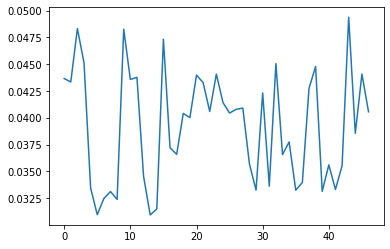

In [37]:
plt.plot(dur)

In [40]:
all_logits[0]

tensor([[ 0.0274,  0.1063, -0.2571,  ...,  0.1726, -0.0389,  0.2666],
        [ 0.0674,  0.1575, -0.2600,  ...,  0.1204, -0.0683,  0.2318],
        [ 0.0496,  0.2279, -0.2571,  ...,  0.0891, -0.0409,  0.2383],
        ...,
        [ 0.0401,  0.1312, -0.2269,  ...,  0.1321, -0.0521,  0.2514],
        [ 0.0427,  0.1258, -0.2140,  ...,  0.1488, -0.0385,  0.2227],
        [ 0.0447,  0.1231, -0.2346,  ...,  0.1361, -0.0526,  0.2385]])